###  Dim Configuration
input x = 1 x n_samples -conv-> 1 x n_samples -Pow + Sum >  1 x n_samples = resut y

In [10]:
### Generate data
import numpy as np
def Convolution(X, k, ConvW):
    """
    k is and odd number
    :param X: 1 x k, center is the current state
    :param k: kernel size
    :param ConvW: 1 x k

    :return: 1 x n_samples
    """
    y = np.zeros(1, dtype = np.complex128)
    for i in range(k):

        y += ConvW[i] * X[i]
    return y

def Polynomial(X, p ,PolyW, scaling_factor=0.05):
    """
    :param X: 1 x 1, complex number
    :param p: polynomial order, p = 3 means 1, 3, 5 
    :param PolyW: 1 x p coefficients
    :return: y : 1 x 1 complex number
    """
    ### PolyW should initailized small values to avoid large y values
    y = np.zeros(1,dtype = np.complex128)
    for i in range(p):
        y += PolyW[i]  * np.pow(np.abs(X * scaling_factor), i) * X
    return y

def Noise(X, noise_level):
    """
    :param X: 1 x 1, complex number
    :param noise_level: noise level
    :return: y: 1 x 1
    """
    return X + noise_level * np.random.randn(1)

def generate_data(n_samples, ConvW, PolyW, noise_level = 0.05, k = 3, p = 3 ):
    # generate complex data

    x = np.random.rand(n_samples) + 1j * np.random.rand(n_samples)  #  1 x n_samples

    ### Convolution
    ConvX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(k//2, n_samples-k//2):
        ### turn into scalar
        # np
        # np
        ConvX[i] = np.array((Convolution(x[i-k//2:i+k//2+1], k, ConvW))[0])
    ### Noise
    # for i in range(k//2, n_samples-k//2):
    #     ConvX[i] = Noise(ConvX[i], noise_level)

    ### Polynomial
    PolyX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(n_samples):
        PolyX[i] = Polynomial(ConvX[i], p, PolyW)[0]
    ### Noise
    # for i in range(n_samples):
    #     PolyX[i] = Noise(PolyX[i], noise_level)
    

    y = PolyX
    return x, y


### Generate Data

In [11]:

##  True parameters, complex 
scaling_factor = 0.1
n_samples = 5000
k = 3
p = 3 
noise_level = 0.05
## set seed
np.random.seed(3)

TruePolyW = np.random.rand(p) + 1j * np.random.rand(p)
for i in range(p):
    TruePolyW[i] = np.power(scaling_factor, i) * TruePolyW[i]
TrueConvW = np.random.rand(k) + 1j * np.random.rand(k)

# b = np.array([0.06799017+0.j        , 0.82173153+0.26699676j,
#        0.0550052 +0.03996362j])
# TrueConvW = b 


x, y = generate_data(n_samples, TrueConvW, TruePolyW, noise_level, k,p)
print(x[:5])
print(y[:5])


[0.64914405+0.46538662j 0.27848728+0.18445508j 0.6762549 +0.77246195j
 0.59086282+0.91535143j 0.02398188+0.71798135j]
[ 0.        +0.j         -0.04062887+0.29855118j -0.26269059+0.68752003j
 -0.37295454+0.68997297j -0.4438131 +0.33229489j]


### Model Designing

In [12]:
### LMS 
def LMS_Filter(x, y, k, p, mu = 0.01, epoch = 10, scalingFactor = 0.1):    
    """
    :param x: 1 x n_samples
    :param y: 1 x n_samples
    :param k: kernel size
    :param p: polynomial order
    :param mu: learning rate
    :return: (ConvW, PolyW)
    """
    ### Initialization
    n_samples = len(x)
    ConvW = np.random.rand(k) + 1j * np.random.rand(k)
    PolyW = np.random.rand(p) + 1j * np.random.rand(p)
    for i in range(p):
        PolyW[i] = np.power(scalingFactor, i) * PolyW[i]

    ### LMS
    PolyRecord = []    
    ConvRecord = []
    ErrorRecord = []

    for j in range(epoch):
        for i in range(k//2, n_samples-k//2):
            
            # calculate error 
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e1", np.abs(e))


            # update coefficients
            ## PolyW
            PolyW += mu *  e * np.conj(ConvX )

            # calculate error
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e2", np.abs(e))

            ## ConvW
            StarPart = np.zeros(p, dtype = np.complex128)
            NonStarPart = np.zeros(p, dtype = np.complex128)
            for l in range(p):
                StarPart[l] = (l+1) * np.power(np.abs(ConvX), l)[0] 
                if(l == 0):          
                    NonStarPart[l] = 0
                else :
                    NonStarPart[l] = l * np.power(ConvX, 2)[0] * np.power(np.abs(ConvX), l-1)[0]
            
            ConvW += mu *  e * np.dot(np.conj(PolyW) , StarPart) * np.conj(x[i-k//2:i+k//2+1]) +\
                mu * np.conj(e) * np.dot(PolyW, NonStarPart) * np.conj(x[i-k//2:i+k//2+1])
            
            # calculate error
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e3", np.abs(e))
            
            ### calculate total error
            # print(i)
            if i % 100 ==  0 : 
                ERROR = np.zeros(1, dtype = np.complex128)
                for l in range(k//2, n_samples-k//2):
                    ConvX = Convolution(x[l-k//2:l+k//2+1], k, ConvW)
                    PolyX = Polynomial(ConvX, p, PolyW)
                    e = y[l] - PolyX
                    ERROR += np.abs(e)
                ErrorRecord.append(np.abs(ERROR))

            ConvRecord.append(ConvW.copy())
            PolyRecord.append(PolyW.copy())
    return ConvRecord, PolyRecord, ErrorRecord


### Example 

In [13]:
### Example usage
ConvRecord, PolyRecord,ErrorRecord = LMS_Filter(x, y, k,p, mu = 0.01, epoch = 10, scalingFactor = 0.1)

In [14]:
### print results
print("True ConvW: ", TrueConvW)
print("Estimated ConvW: ", ConvRecord[-1])
print("True PolyW: ", TruePolyW)
print("Estimated PolyW: ", PolyRecord[-1])


True ConvW:  [0.06799017+0.j         0.82173153+0.26699676j 0.0550052 +0.03996362j]
Estimated ConvW:  [-0.04400569+0.02143903j -0.58032445+0.08637138j -0.04807707-0.00770597j]
True PolyW:  [0.5507979 +0.51082761j 0.07081478+0.0892947j  0.00290905+0.00896293j]
Estimated PolyW:  [-0.3764051 -0.99295136j -0.45870633-1.4124426j  -0.52495708-1.41071358j]


### Plot 

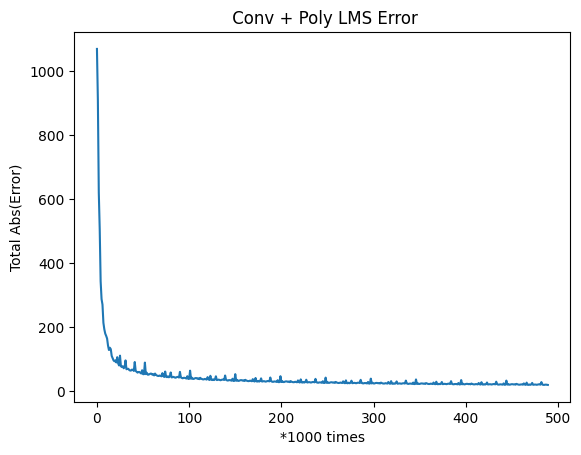

In [15]:
### plot the coefficients
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ErrorRecord)
plt.xlabel("*1000 times")
plt.ylabel("Total Abs(Error)")
plt.title(" Conv + Poly LMS Error")
plt.show()  


In [16]:
ErrorRecord[-1] / n_samples

array([0.00391208])

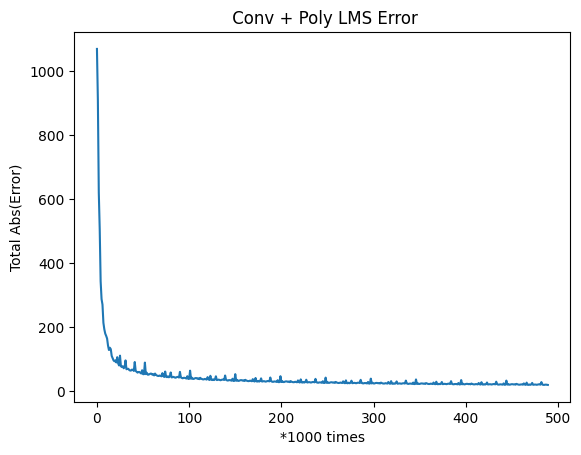

: 

In [17]:
### save plot 
plt.figure()
plt.plot(ErrorRecord)
plt.xlabel("*1000 times")
plt.ylabel("Total Abs(Error)")
plt.title(" Conv + Poly LMS Error")
plt.savefig("ConvPolyLMS.png")